# Lab | Making predictions with logistic regression

In this lab, you will be using the Sakila database of movie rentals.

In order to optimize our inventory, we would like to know which films will be rented next month and we are asked to create a model to predict it.

Instructions

1. Create a query or queries to extract the information you think may be relevant for building the prediction model. It should include some film features and some rental features.

2. Read the data into a Pandas dataframe.

3. Analyze extracted features and transform them. You may need to encode some categorical variables, or scale numerical variables.

4. Create a query to get the list of films and a boolean indicating if it was rented last month. This would be our target variable.

5. Create a logistic regression model to predict this variable from the cleaned data.

6. Evaluate the results.

In [2]:
import pymysql
from sqlalchemy import create_engine
import pandas as pd
import numpy as np
import getpass
import matplotlib.pyplot as plt 
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
password = getpass.getpass()

········


Get the data

Case 2:

We will be trying to predict if a film will be rented this month based on their previous activity and other details. We will first construct a table with:

Film ID
Category
Total number of copies per film
*Bonus - How many "stars" acts in the film*
How many times the film was rented last month (MAY/2005)
If the film was rented this month (JUNE/2005)
Once you extract that information, and any other that seems fit, predict which films will be rented this month.

Extra Suggestions:

Format your notebook as a report, in a way that someone who didn't know your project could read and understand. Write down your hypothesis, what data you think it's important to check the hypothesis.

Have a notebook with general EDA, but on the final notebook have only the focused EDA.

Explain any transformation/scaling/feature engineering you apply (no need to explain data cleaning steps).

Write some conclusions: how would this prediction impact the business? what are your constraints in this business case? is it a good predictive model? any problems you suspect of? any ideas on how to solve the problem and/or improve the model?

Bonus - Challenge: Choose another target variable and explore other possibilities of predictions. Make sure to explain your business application and hypothesis.

In [3]:
connection_string = 'mysql+pymysql://root:' + password + '@localhost/sakila'
engine = create_engine(connection_string)
query = """
select f.film_id, title, c.name as 'Genre', rental_rate,  date_format(convert(rental_date, date), '%%Y') as Year_, date_format(convert(rental_date, date), '%%m') as Month_, count(rental_id) as Number_of_rentals, count(a.actor_id) as Number_of_stars from film f
left join film_category fc on f.film_id = fc.film_id
left join category c on fc.category_id = c.category_id
left join inventory i on f.film_id = i.film_id
left join rental r on i.inventory_id = r.inventory_id
left JOIN film_actor fa on f.film_id = fa.film_id
left join actor a on fa.actor_id = a.actor_id
where a.actor_id IN (1,10, 20, 30, 40, 53, 108, 162, 188, 198)
group by 1,2,3,4, 5, 6
order by 5,6;
"""

data = pd.read_sql_query(query, engine)
data

,film_id,title,Genre,rental_rate,Year_,Month_,Number_of_rentals,Number_of_stars
0,14,ALICE FANTASIA,Classics,0.99,None,None,0,1
1,33,APOLLO TEEN,Drama,2.99,None,None,0,1
2,41,ARSENIC INDEPENDENCE,Travel,0.99,None,None,0,1
3,386,GUMP DATE,Travel,4.99,None,None,0,1
4,1,ACADEMY DINOSAUR,Documentary,0.99,None,None,0,10
...,...,...,...,...,...,...,...,...
901,445,HYDE DOCTOR,Classics,2.99,2006,02,1,1
902,696,PRIDE ALAMO,Animation,0.99,2006,02,1,1
903,945,VIRGINIAN PLUTO,Documentary,0.99,2006,02,1,1
904,869,SUSPECTS QUILLS,Action,2.99,2006,02,1,1


In [4]:
data['Number_of_stars'].value_counts()

1     159
2     149
3     111
4      96
6      81
5      70
7      52
8      45
9      39
10     36
12     18
11     18
14      7
20      4
16      4
18      4
15      3
22      3
90      2
21      2
30      1
28      1
13      1
Name: Number_of_stars, dtype: int64

In [5]:
data['Number_of_rentals'].value_counts()

1     150
2     149
3     111
4      96
6      81
5      70
7      52
8      45
9      39
10     35
11     18
12     18
0      10
14      7
16      4
20      4
18      4
15      3
22      3
90      2
21      2
30      1
28      1
13      1
Name: Number_of_rentals, dtype: int64

In [6]:
data.shape

(906, 8)

In [7]:
data.dtypes

film_id                int64
title                 object
Genre                 object
rental_rate          float64
Year_                 object
Month_                object
Number_of_rentals      int64
Number_of_stars        int64
dtype: object

In [8]:
data.describe()

,film_id,rental_rate,Number_of_rentals,Number_of_stars
count,906.000000,906.000000,906.000000,906.000000
mean,506.390728,2.839890,5.030905,5.051876
std,288.062136,1.624258,5.584819,5.576644
min,1.000000,0.990000,0.000000,1.000000
25%,274.000000,0.990000,2.000000,2.000000
50%,517.000000,2.990000,4.000000,4.000000
75%,744.000000,4.990000,7.000000,7.000000
max,997.000000,4.990000,90.000000,90.000000


In [9]:
data.isna().sum()

film_id               0
title                 0
Genre                 0
rental_rate           0
Year_                10
Month_               10
Number_of_rentals     0
Number_of_stars       0
dtype: int64

# Clean the data

In [10]:
def columns_clean(dataframe):
    dataframe.columns = [dataframe.columns[i].title().replace(' ','_') for i in range(len(dataframe.columns))]
    return dataframe

#data.columns = [data.columns[i].upper().replace(' ','_') for i in range(len(data.columns))]
#data

columns_clean(data)
data

,Film_Id,Title,Genre,Rental_Rate,Year_,Month_,Number_Of_Rentals,Number_Of_Stars
0,14,ALICE FANTASIA,Classics,0.99,None,None,0,1
1,33,APOLLO TEEN,Drama,2.99,None,None,0,1
2,41,ARSENIC INDEPENDENCE,Travel,0.99,None,None,0,1
3,386,GUMP DATE,Travel,4.99,None,None,0,1
4,1,ACADEMY DINOSAUR,Documentary,0.99,None,None,0,10
...,...,...,...,...,...,...,...,...
901,445,HYDE DOCTOR,Classics,2.99,2006,02,1,1
902,696,PRIDE ALAMO,Animation,0.99,2006,02,1,1
903,945,VIRGINIAN PLUTO,Documentary,0.99,2006,02,1,1
904,869,SUSPECTS QUILLS,Action,2.99,2006,02,1,1


In [11]:
data = data[data['Year_'].isna() == False]

In [12]:
data = data[data['Month_'].isna() == False]

In [13]:
data


,Film_Id,Title,Genre,Rental_Rate,Year_,Month_,Number_Of_Rentals,Number_Of_Stars
10,930,VACATION BOONDOCK,Sci-Fi,2.99,2005,05,2,2
11,492,JUNGLE CLOSER,New,0.99,2005,05,2,2
12,366,GOLDFINGER SENSIBILITY,Drama,0.99,2005,05,4,4
13,23,ANACONDA CONFESSIONS,Animation,0.99,2005,05,2,2
14,723,REIGN GENTLEMEN,Sci-Fi,2.99,2005,05,1,1
...,...,...,...,...,...,...,...,...
901,445,HYDE DOCTOR,Classics,2.99,2006,02,1,1
902,696,PRIDE ALAMO,Animation,0.99,2006,02,1,1
903,945,VIRGINIAN PLUTO,Documentary,0.99,2006,02,1,1
904,869,SUSPECTS QUILLS,Action,2.99,2006,02,1,1


In [14]:
data.isna().sum()

Film_Id              0
Title                0
Genre                0
Rental_Rate          0
Year_                0
Month_               0
Number_Of_Rentals    0
Number_Of_Stars      0
dtype: int64

In [15]:
data.shape

(896, 8)

In [16]:
data.dtypes

Film_Id                int64
Title                 object
Genre                 object
Rental_Rate          float64
Year_                 object
Month_                object
Number_Of_Rentals      int64
Number_Of_Stars        int64
dtype: object

In [18]:
data1 = data.select_dtypes('object')
data1

,Title,Genre,Year_,Month_
10,VACATION BOONDOCK,Sci-Fi,2005,05
11,JUNGLE CLOSER,New,2005,05
12,GOLDFINGER SENSIBILITY,Drama,2005,05
13,ANACONDA CONFESSIONS,Animation,2005,05
14,REIGN GENTLEMEN,Sci-Fi,2005,05
...,...,...,...,...
901,HYDE DOCTOR,Classics,2006,02
902,PRIDE ALAMO,Animation,2006,02
903,VIRGINIAN PLUTO,Documentary,2006,02
904,SUSPECTS QUILLS,Action,2006,02


In [19]:
for i in data1:
    print(data1[i].value_counts(), '\n')

AFFAIR PREJUDICE       5
SLEEPY JAPANESE        5
MOONWALKER FOOL        5
WEDDING APOLLO         5
GLEAMING JAWBREAKER    5
                      ..
CASSIDY WYOMING        2
OKLAHOMA JUMANJI       2
VERTIGO NORTHWEST      2
ALABAMA DEVIL          2
GILBERT PELICAN        2
Name: Title, Length: 235, dtype: int64 

Sports         78
Documentary    71
Animation      68
Action         66
New            65
Sci-Fi         64
Horror         61
Classics       60
Travel         56
Comedy         55
Foreign        54
Music          49
Games          44
Drama          41
Family         36
Children       28
Name: Genre, dtype: int64 

2005    855
2006     40
2021      1
Name: Year_, dtype: int64 

07    235
08    235
06    221
05    164
02     40
10      1
Name: Month_, dtype: int64 



In [58]:
"""number of rentals and number of starts as categorical
data['Number_Of_Rentals'] = data['Number_Of_Rentals'].astype('object')
data['Number_Of_Stars'] = data['Number_Of_Stars'].astype('object')
data.dtypes"""

Film_Id                int64
Title                 object
Genre                 object
Rental_Rate          float64
Year_                 object
Month_                object
Number_Of_Rentals     object
Number_Of_Stars       object
dtype: object

In [27]:

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 10)

In [31]:
for i in data.select_dtypes('object'):
    print(data[i].value_counts(), '\n')

AFFAIR PREJUDICE       5
SLEEPY JAPANESE        5
MOONWALKER FOOL        5
WEDDING APOLLO         5
GLEAMING JAWBREAKER    5
                      ..
CASSIDY WYOMING        2
OKLAHOMA JUMANJI       2
VERTIGO NORTHWEST      2
ALABAMA DEVIL          2
GILBERT PELICAN        2
Name: Title, Length: 235, dtype: int64 

Sports         78
Documentary    71
Animation      68
Action         66
New            65
               ..
Music          49
Games          44
Drama          41
Family         36
Children       28
Name: Genre, Length: 16, dtype: int64 

2005    855
2006     40
2021      1
Name: Year_, dtype: int64 

07    235
08    235
06    221
05    164
02     40
10      1
Name: Month_, dtype: int64 



In [34]:
data['Number_Of_Rentals'] = data['Number_Of_Rentals'].astype('object')
data.dtypes

Film_Id                int64
Title                 object
Genre                 object
Rental_Rate          float64
Year_                 object
Month_                object
Number_Of_Rentals     object
Number_Of_Stars        int64
dtype: object

In [56]:
"""# clean operation
def clean_empty_cells(x):
    if len(x) < 1:
        return 'Unknown'
    else:
        return x.lower()
"""    

In [60]:
#for col in ['Number_Of_Rentals', 'Number_Of_Stars' ]:
  #  data[col] = data[col].apply(clean_empty_cells)

# Feature engineering


In [44]:
y = data['Number_Of_Rentals'].astype('int')
x = data.drop('Number_Of_Rentals', axis = 1)

In [45]:
x = pd.get_dummies(x)
x

,Film_Id,Rental_Rate,Number_Of_Stars,Title_ACADEMY DINOSAUR,Title_AFFAIR PREJUDICE,Title_AGENT TRUMAN,Title_AIRPLANE SIERRA,Title_ALABAMA DEVIL,Title_ALADDIN CALENDAR,Title_ALAMO VIDEOTAPE,Title_ALTER VICTORY,Title_ANACONDA CONFESSIONS,Title_ANGELS LIFE,Title_ANTHEM LUKE,Title_APOCALYPSE FLAMINGOS,Title_ARABIA DOGMA,Title_BALLOON HOMEWARD,Title_BANG KWAI,Title_BANGER PINOCCHIO,Title_BEACH HEARTBREAKERS,Title_BEDAZZLED MARRIED,Title_BEETHOVEN EXORCIST,Title_BEVERLY OUTLAW,Title_BIRDS PERDITION,Title_BONNIE HOLOCAUST,Title_BUBBLE GROSSE,Title_BULWORTH COMMANDMENTS,Title_BUNCH MINDS,Title_BUTTERFLY CHOCOLAT,Title_CADDYSHACK JEDI,Title_CAROL TEXAS,Title_CARRIE BUNCH,Title_CASSIDY WYOMING,Title_CASUALTIES ENCINO,Title_CHARADE DUFFEL,Title_CHEAPER CLYDE,Title_CHITTY LOCK,Title_CLYDE THEORY,Title_COAST RAINBOW,Title_COLDBLOODED DARLING,Title_COLOR PHILADELPHIA,Title_CONNECTICUT TRAMP,Title_CONTACT ANONYMOUS,Title_CRAFT OUTFIELD,Title_CROOKED FROGMEN,Title_DANCING FEVER,Title_DARES PLUTO,Title_DEEP CRUSADE,Title_DESIRE ALIEN,Title_DINOSAUR SECRETARY,Title_DISCIPLE MOTHER,Title_DIVINE RESURRECTION,Title_DOOM DANCING,Title_DOORS PRESIDENT,Title_DRAGONFLY STRANGERS,Title_DROP WATERFRONT,Title_DUDE BLINDNESS,Title_DUMBO LUST,Title_DWARFS ALTER,Title_EARLY HOME,Title_EARRING INSTINCT,Title_EGG IGBY,Title_ELEPHANT TROJAN,Title_ELF MURDER,Title_ELIZABETH SHANE,Title_ENGLISH BULWORTH,Title_ENOUGH RAGING,Title_EVE RESURRECTION,Title_EXCITEMENT EVE,Title_FAMILY SWEET,Title_FANTASIA PARK,Title_FANTASY TROOPERS,Title_FELLOWSHIP AUTUMN,Title_FEUD FROGMEN,Title_FICTION CHRISTMAS,Title_FLASH WARS,Title_FLATLINERS KILLER,Title_FLYING HOOK,Title_FORREST SONS,Title_FRISCO FORREST,Title_GAMES BOWFINGER,Title_GANDHI KWAI,Title_GARDEN ISLAND,Title_GILBERT PELICAN,Title_GILMORE BOILED,Title_GLEAMING JAWBREAKER,Title_GOLDFINGER SENSIBILITY,Title_GRAFFITI LOVE,Title_GREATEST NORTH,Title_GREEDY ROOTS,Title_HAMLET WISDOM,Title_HANDICAP BOONDOCK,Title_HANGING DEEP,Title_HAUNTING PIANIST,Title_HEARTBREAKERS BRIGHT,Title_HEAVEN FREEDOM,Title_HEAVYWEIGHTS BEAST,Title_HIGH ENCINO,Title_HUMAN GRAFFITI,Title_HYDE DOCTOR,Title_ICE CROSSING,Title_IDOLS SNATCHERS,Title_INSTINCT AIRPORT,Title_INTENTIONS EMPIRE,Title_INTERVIEW LIAISONS,Title_INTOLERABLE INTENTIONS,Title_JAWBREAKER BROOKLYN,Title_JAWS HARRY,Title_JEEPERS WEDDING,Title_JEOPARDY ENCINO,Title_JUMANJI BLADE,Title_JUNGLE CLOSER,Title_KARATE MOON,Title_KING EVOLUTION,Title_KISS GLORY,Title_LADY STAGE,Title_LADYBUGS ARMAGEDDON,Title_LAMBS CINCINATTI,Title_LANGUAGE COWBOY,Title_LESSON CLEOPATRA,Title_LIAISONS SWEET,Title_LIES TREATMENT,Title_LIFE TWISTED,Title_LOLA AGENT,Title_LONELY ELEPHANT,Title_LORD ARIZONA,Title_LOSE INCH,Title_LOVELY JINGLE,Title_LOVERBOY ATTACKS,Title_LUKE MUMMY,Title_MADNESS ATTACKS,Title_MALLRATS UNITED,Title_MASK PEACH,Title_MATRIX SNOWMAN,Title_MAUDE MOD,Title_MEET CHOCOLATE,Title_MEMENTO ZOOLANDER,Title_MERMAID INSECTS,Title_MICROCOSMOS PARADISE,Title_MIDNIGHT WESTWARD,Title_MIGHTY LUCK,Title_MILE MULAN,Title_MOD SECRETARY,Title_MODEL FISH,Title_MODERN DORADO,Title_MONTEREY LABYRINTH,Title_MOONWALKER FOOL,Title_MULHOLLAND BEAST,Title_MUMMY CREATURES,Title_MUSSOLINI SPOILERS,Title_NORTHWEST POLISH,Title_OKLAHOMA JUMANJI,Title_OLEANDER CLUE,Title_ORIENT CLOSER,Title_OUTLAW HANKY,Title_PAJAMA JAWBREAKER,Title_PANTHER REDS,Title_PARK CITIZEN,Title_PATHS CONTROL,Title_PATIENT SISTER,Title_PERSONAL LADYBUGS,Title_POTTER CONNECTICUT,Title_PREJUDICE OLEANDER,Title_PRIDE ALAMO,Title_PRIMARY GLASS,Title_PULP BEVERLY,Title_PUNK DIVORCE,Title_RANDOM GO,Title_REAP UNFAITHFUL,Title_REAR TRADING,Title_REDS POCUS,Title_REIGN GENTLEMEN,Title_REQUIEM TYCOON,Title_RESURRECTION SILVERADO,Title_RINGS HEARTBREAKERS,Title_RIVER OUTLAW,Title_ROCK INSTINCT,Title_ROMAN PUNK,Title_ROOTS REMEMBER,Title_ROSES TREASURE,Title_ROXANNE REBEL,Title_RULES HUMAN,Title_RUSHMORE MERMAID,Title_SAGEBRUSH CLUELESS,Title_SAINTS BRIDE,Title_SCISSORHANDS SLUMS,Title_SEABISCUIT PUNK,Title_SEARCHERS WAIT,Title_SHAKESPEARE SADDLE,T

In [46]:
x_train, x_test, y_train, y_test = train_test_split(x,y, test_size = 0.2, random_state = 42)

In [47]:
model = LogisticRegression( random_state = 42, max_iter = 500)
model.fit(x_train, y_train)

c:\users\31645\appdata\local\programs\python\python39\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(max_iter=500, random_state=42)

In [41]:
#dataset = data.values
#dataset

array([[930, 'VACATION BOONDOCK', 'Sci-Fi', ..., '05', 2, 2],
       [492, 'JUNGLE CLOSER', 'New', ..., '05', 2, 2],
       [366, 'GOLDFINGER SENSIBILITY', 'Drama', ..., '05', 4, 4],
       ...,
       [945, 'VIRGINIAN PLUTO', 'Documentary', ..., '02', 1, 1],
       [869, 'SUSPECTS QUILLS', 'Action', ..., '02', 1, 1],
       [1, 'ACADEMY DINOSAUR', 'Documentary', ..., '10', 10, 10]],
      dtype=object)

In [43]:
#x.shape

(896, 263)

In [48]:
model.score(x_test, y_test)

0.3277777777777778

In [59]:
y_predicted = model.predict(x_test)

In [61]:
pd.Series(y_predicted).value_counts()


1     43
6     32
4     30
2     24
3     21
10    15
7      8
8      6
90     1
dtype: int64

In [83]:
cm = confusion_matrix(y_test[0:4], y_predicted[0:4])
cm

array([[0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 1, 0, 0],
       [0, 0, 1, 0, 0, 0],
       [0, 0, 0, 0, 0, 1]], dtype=int64)

TypeError: 'str' object is not callable

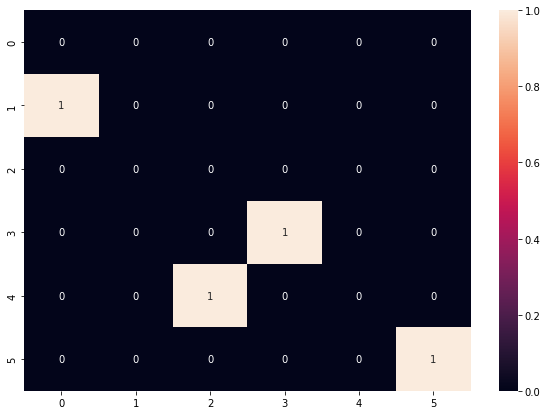

In [84]:
plt.figure(figsize = (10,7))
sns.heatmap(cm, annot = True, ax = None)
plt.xlabel('Predicted')
plt.ylabel('Truth')

c:\users\31645\appdata\local\programs\python\python39\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


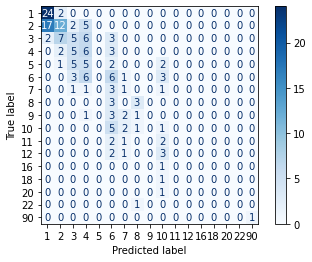

In [80]:
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(model, x_test, y_test, cmap = 'Blues')
plt.show()

<AxesSubplot:>

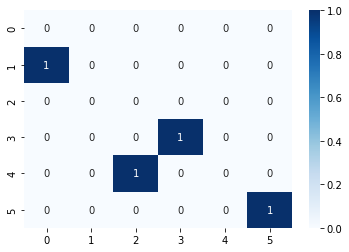

In [87]:
 
group_names = ['True 1', 'False 1', 'False 1', 'False 1',
               'False 2', 'True 2', 'False 2', 'False 2',
               'False 3', 'False 3', 'True 3', 'False 3',
               'False 4', 'False 4', 'False 4', 'True 4']
group_counts = ["{0:0.0f}".format(value) for value in cm.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in cm.flatten()/np.sum(cm)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(4,4)
sns.heatmap(cm, annot=True, fmt='', cmap='Blues')